In [104]:
# Import libraries
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from numpy.polynomial import polynomial as P

In [105]:
# Times are in minutes
stations = [
    #Station Name,          East,   West
    ("Recto",               2.00,   7.00),
    ("Legarda",             2.75,   2.00),
    ("Pureza",              2.75,   2.75),
    ("V. Mapa",             2.50,   2.75),
    ("J. Ruiz",             1.75,   2.50),
    ("Gilmore",             2.25,   1.75),
    ("Betty-Go Belmonte",   2.25,   2.25),
    ("Araneta Cubao",       3.00,   2.25), 
    ("Anonas",              2.00,   3.00),
    ("Katipunan",           4.00,   2.00),
    ("Santolan",            3.50,   4.00),
    ("Marikina-Pasig",      4.50,   3.50),   
    ("Antipolo",            0.00,   4.50)
]

NSTATIONS = len(stations)



In [106]:
days = {
    "monday": {},
    "tuesday": {},
    "wednesday": {},
    "thursday": {},
    "friday": {},
    "saturday": {},
    "sunday": {}
}

def read_data(filename):
    """Reads data from a file and returns a numpy array of the data"""
    data = pd.read_csv(filename, header=0)
    return data

monday_raw = read_data("Monday.csv")
days["monday"]["cum"] = monday_raw.cumsum()
days["monday"]["ntrains"] = [(9, 5), (8, 4), (9, 9)]

tuesday_raw = read_data("Tuesday.csv")
days["tuesday"]["cum"] = tuesday_raw.cumsum()
days["tuesday"] ["ntrains"] = [(9, 4.5), (8, 5.5), (9, 8)]

wednesday_raw = read_data("Wednesday.csv")
days["wednesday"]["cum"] = wednesday_raw.cumsum()
days["wednesday"]["ntrains"] = [(9, 4.5), (8, 5), (9, 8.5)]

thursday_raw = read_data("Thursday.csv")
days["thursday"]["cum"] = thursday_raw.cumsum()
days["thursday"]["ntrains"] = [(9, 6), (8, 4), (9, 8)]

friday_raw = read_data("Friday.csv")
days["friday"]["cum"] = friday_raw.cumsum()
days["friday"]["ntrains"] = [(9, 4.5), (8, 5.5), (9, 8)]

saturday_raw = read_data("Saturday.csv")
days["saturday"]["cum"] = saturday_raw.cumsum()
days["saturday"]["ntrains"] = [(8, 18)]

sunday_raw = read_data("Sunday.csv")
days["sunday"]["cum"] = sunday_raw.cumsum()
days["sunday"]["ntrains"] = [(7, 18)]

# monday_cum

In [107]:
class Station():
    def __init__(self, name, entry_coeffs, exit_coeffs, idx, east_time, west_time):
        self.name = name
        # entry and exit in hours
        self.entry = P.Polynomial(entry_coeffs)
        self.exit = P.Polynomial(exit_coeffs)
        self.idx = idx
        self.east_time = east_time
        self.west_time = west_time

        # next stations
        self.east_next = None
        self.west_next = None

        # number of passengers waiting
        self.east_bound = 0
        self.west_bound = 0

        # number of potentially exiting passengers
        self.east_exiting = 0
        self.west_exiting = 0

    def step(self, start, step_size):
        # entering passengers
        entering = max(0, self.entry(start + step_size) - self.entry(start))

        self.east_bound += entering * (12 - self.idx) / 12
        self.west_bound += entering * self.idx / 12
        
        # potentially exiting passengers
        exiting = max(0, self.exit(start + step_size) - self.exit(start))

        self.east_exiting += exiting * self.idx / 12
        self.west_exiting += exiting * (12 - self.idx) / 12

        # print(self.name.ljust(20, ' '), end='')
        # print(", ".join([str(round(x, 2)).rjust(5, ' ') for x in [entering, self.east_bound, self.west_bound, self.east_exiting, self.west_exiting]]))

    def __str__(self):
        return self.name


class Depot():
    def __init__(self, name, headway, global_state, next_station):
        self.name = name
        self.headway = headway
        self.global_state = global_state
        self.next_station = next_station

        self.queue = []
        self.timer = 0
    
    def step(self, step_size):
        self.timer += step_size

        # print("Depot timer:", self.timer * 60, "headway:", self.headway)
        # print("Depot queue:", [x.name for x in self.queue])

        if self.timer * 60 >= self.headway - 0.001:
            if len(self.queue) <= 0:
                return

            train = self.queue.pop(0)
            train.next_station = self.next_station
            train.time_left = 0
            train.east = False

            # self.global_state.release_train(self.next_station, train.name, 0, False)
            self.timer = 0

    def reset_timer(self):
        self.timer = 0
    
    def enqueue(self, train):        
        self.queue.append(train)


class Train():
    def __init__(self, capacity, name, start_station, east, time_to_active):
        self.capacity = capacity
        self.name = name

        self.passengers = 0
        self.passenger_history = [(0, 0)]
        self.time_left = time_to_active
        self.east = east
        self.next_station = start_station

        # print("Train", self.name, "will start at", self.next_station.name, "in", round(self.time_left * 60, 2), "minutes")
    
    def step(self, time, step_size, headway, global_state):        
        self.time_left -= step_size

        # print("Train", self.name, "en route to", self.next_station.name, "eastbound" if self.east else "westbound", "with", round(self.time_left * 60, 2), "minutes left")
        if self.time_left <= 0.0001:
            curr_station = self.next_station

            # print("\nTrain", self.name, "arrived at", curr_station.name)
            Global.load_unload_passengers(time, self, curr_station, self.east)
            self.passenger_history.append((time, self.passengers))
            
            # reverse direction if in Recto
            if not self.east and curr_station == curr_station.west_next:
                self.east = True

            if not self.east and curr_station == global_state.stations[-1]:
                global_state.depot.reset_timer()

            if self.next_station == global_state.depot:
                global_state.depot.enqueue(self)


class Global():
    total_time = 2 * sum([x[2] for x in stations])

    def __init__(self, step_size, stations, ntrains):
        self.step_size = step_size
        self.stations = stations
        self.time = 0
        self.ids = list(range(1, 100))

        self.ntrains = ntrains
        self.headway = round(Global.total_time / ntrains * 4) / 4

        self.trains = []

        self.depot = Depot("Depot", self.headway, self, self.stations[-1])
        self.history = []


    def step(self, count = 1, max_capacity = 1):
        for i in range(count):
            # print("\nTime: ", round(self.time * 60, 2), "minutes")

            self.depot.step(self.step_size)

            for station in self.stations:
                station.step(self.time, self.step_size)
            
            max_passengers = 0

            for train in self.trains:
                if train.next_station == self.depot:
                    continue

                train.step(self.time, self.step_size, self.headway, self)

                if train.passengers > max_passengers:
                    max_passengers = train.passengers
            
            self.history.append((round(self.time * 60 * 4) / 4, max_passengers/max_capacity))

            self.time += self.step_size


    def release_train(self, station, name, time_to_active, east):
        train = Train(SEATING_CAP + STANDING_3CAP, name, station, east, time_to_active)
        self.trains.append(train)

        if station.name == "Depot":
            self.depot.enqueue(train)

    
    def add_train(self):
        self.ntrains += 1
        self.headway = round(Global.total_time / self.ntrains * 4) / 4
        
        self.depot.headway = self.headway

        # print(self.stations[-1].last_west, self.headway, self.time)
        # time_left = max(0, self.stations[-1].last_west + self.headway / 60 - self.time)

        # print(f"New train will be released in depot")
        
        self.release_train(self.depot, self.ids.pop(0), 0, False)
    

    def remove_train(self):
        self.ntrains -= 1
        self.headway = round(Global.total_time / self.ntrains * 4) / 4

        self.depot.headway = self.headway


    @staticmethod
    def load_unload_passengers(time, train, station, east):
        # print(station.name.ljust(20, ' '), end='')
        # print(", ".join([str(round(x, 2)).rjust(5, ' ') for x in [station.east_bound, station.west_bound, station.east_exiting, station.west_exiting]]))
    
        if east:
            # Unload passengers
            exiting_passengers = max(0, math.floor(station.east_exiting))
            exiting_passengers = min(exiting_passengers, train.passengers)

            # print("Unloading", exiting_passengers, "passengers")
            train.passengers -= exiting_passengers
            station.east_exiting -= exiting_passengers

            # load passengers
            loading_passengers = max(0, math.floor(station.east_bound))

            # print("Loading", loading_passengers, "passengers")
            train.passengers += loading_passengers
            station.east_bound -= loading_passengers

            # print("Train", train.name, "has", train.passengers, "passengers")

            train.time_left = station.east_time
            train.next_station = station.east_next
        else:
            # Set last west
            station.last_west = time
            
            # Unload passengers
            exiting_passengers = max(0, math.floor(station.west_exiting))
            exiting_passengers = min(exiting_passengers, train.passengers)

            # print("Unloading", exiting_passengers, "passengers")
            train.passengers -= exiting_passengers
            station.west_exiting -= exiting_passengers

            # load passengers
            loading_passengers = max(0, math.floor(station.west_bound))

            # print("Loading", loading_passengers, "passengers")
            train.passengers += loading_passengers
            station.west_bound -= loading_passengers

            # print("Train", train.name, "has", train.passengers, "passengers")

            train.time_left = station.west_time
            train.next_station = station.west_next


In [108]:
SEATING_CAP = 232
STANDING_3CAP = 594
STANDING_4CAP = 793
STANDING_7CAP = 1396

day_df = {}

# day_df{day : [interpolated_df, num_trains]}

for day in days:
    interpolated = {}
    for name, series in days[day]["cum"].items():
        x = days[day]["cum"].index.values
        y = series.values

        poly = P.polyfit(x, y, 10)

        interpolated[name] = poly

        
    interpolated_df = pd.DataFrame(list(interpolated.items()), columns=['Name', 'Coefficients'])

    day_df[day] = interpolated_df

# P.Polynomial(interpolated_df[interpolated_df['Name'] == 'Recto:Entry']['Coefficients'].values[0])

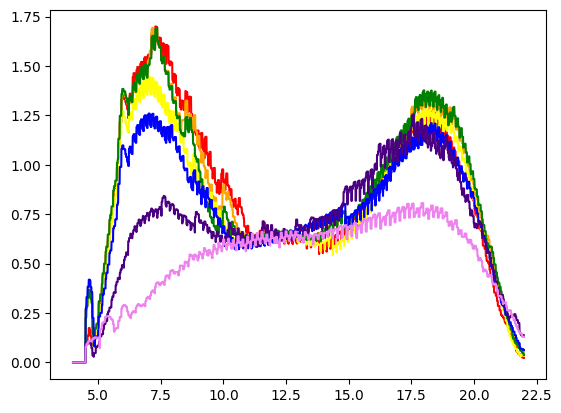

In [109]:
results = {}
for day in day_df:

    station_objs = []
    train_objs = []

    curr_num = days[day]["ntrains"][0][0]

    for station in stations:
        entry_poly = day_df[day][day_df[day]['Name'] == station[0] + ':Entry']['Coefficients'].values[0]
        exit_poly = day_df[day][day_df[day]['Name'] == station[0] + ':Exit']['Coefficients'].values[0]

        station_instance = Station(station[0], entry_poly, exit_poly, stations.index(station), station[1] / 60, station[2] / 60)

        station_objs.append(station_instance)

    for i in range(len(station_objs) - 1):
        station_objs[i].east_next = station_objs[i + 1]
        station_objs[i + 1].west_next = station_objs[i]
    
    station_objs[0].west_next = station_objs[0]
        
    global_state = Global(0.25/60, station_objs, curr_num)    
    global_state.stations[-1].east_next = global_state.depot    
    global_state.depot.west_next = global_state.stations[-1]
        
    half = math.floor(global_state.ntrains / 2)
        
    for i in range(half):
        global_state.release_train(station_objs[0], global_state.ids.pop(0), (i * global_state.headway + 30.25) / 60, True)
        train_objs.append(global_state.trains[-1])

    for i in range(half, global_state.ntrains):
        global_state.release_train(station_objs[-1], global_state.ids.pop(0), ((i - half) * global_state.headway + 30.25) / 60, False)
        train_objs.append(global_state.trains[-1])


    for (count, length) in days[day]["ntrains"]:
        if count > curr_num:
            for i in range(count - curr_num):
                global_state.add_train()
        elif count < curr_num:
            for i in range(curr_num - count):
                global_state.remove_train()
        
        curr_num = count
        global_state.step(int(length * 60 * 4), SEATING_CAP + STANDING_3CAP)


    # # 4 to 6
    # global_state.step(2 * 60 * 4)

    # # 6 to 9
    # # global_state.add_train()
    # global_state.add_train()
    # global_state.step(3 * 60 * 4)

    # # 9 to 16
    # # global_state.remove_train()
    # global_state.remove_train()
    # global_state.step(7 * 60 * 4)

    # # 16 to 19
    # # global_state.add_train()
    # global_state.add_train()
    # global_state.step(3 * 60 * 4)        

    # # 19 to 22
    # # gl    obal_state    .remove_train()
    # global_state.remove_train()
    # global_state.step(3 * 60 * 4)        

        # interpolated_train_poly =     P.polyfit(train_objs[0], train_0_c    ount, 9)

    # print(global_state.history)                

    # history = P.polyfit([x[0] for x in global_state.history], [x[1] for x in global_state.history], 10)

    # P.Polynomial(history)
    results[day] = [[x[0]/60 for x in global_state.history], [x[1] for x in global_state.history]]
plt.plot(results["monday"][0], results["monday"][1], color="red", label="Monday")
plt.plot(results["tuesday"][0], results["tuesday"][1], color="orange", label="Tuesday")
plt.plot(results["wednesday"][0], results["wednesday"][1], color="yellow", label="Wednesday")
plt.plot(results["thursday"][0], results["thursday"][1], color="green", label="Thursday")
plt.plot(results["friday"][0], results["friday"][1], color="blue", label="Friday")
plt.plot(results["saturday"][0], results["saturday"][1], color="indigo", label="Saturday")
plt.plot(results["sunday"][0], results["sunday"][1], color="violet", label="Sunday")
plt.show()


    # 137.77216166−20.41761589x+0.65782308x^2−0.00609801x^3+(2.90592135*10^{-05})x^4−(8.32579123*10^{-08})x^5+(1.51494375*10^{-10})x^6−(1.76372821*10^{-13})x^7+(1.27270759*10^{-16})x^8−(5.18496315*10^{-20})x^9+(9.1169026*10^{-24})x^{10}
    # 113.92309974−16.46376726x+0.51557635x^2−0.00416856x^3+(1.66790986*10^{-05})x^4−(3.92097016*10^{-08})x^5+(5.76222779*10^{-11})x^6−(5.35134735*10^{-14})x^7+(3.04881584*10^{-17})x^8−(9.73778361*10^{-21})x^9+(1.3411779*10^{-24})x^{10}
    # 106.90875466−14.37670454x+0.4210205x^2−0.00273611x^3+(7.02078031*10^{-06})x^4−(3.93449543*10^{-09})x^5−(1.87380712*10^{-11})x^6+(4.74502008*10^{-14})x^7−(4.96074673*10^{-17})x^8+(2.52889191*10^{-20})x^9−(5.15007845*10^{-24})x^{10}                                                        

# TODO
- Figure out how to change NTRAINS dynamically and adjust spacing between trains
- Figure out how to handle initially odd NTRAINS
- Train and station capacity computations